In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from torch.utils.data import DataLoader, TensorDataset
from functions import Rossler, Solution, plot
from ae import Autoencoder
from sindy_utils import sindy_simulate

In [9]:
a, b, c = 0.15, 0.2, 10
h = np.pi/100
t = np.arange(0,100,h)
n = len(t)
x0 =[0.1,1,0.1]
xs,ys,zs = Solution(Rossler, x0, t, [a,b,c])
tau = 17

In [10]:
v1 = np.array(xs[0: n - 2*tau]) #x(t)
v2 = np.array(xs[tau: n - tau]) #x(t + τ)
v3 = np.array(xs[2*tau: n]) #x(t + 2τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])
dv3 = np.gradient(v3, t[:len(v1)])

In [11]:
torch.manual_seed(123)

In [12]:
v = torch.tensor(np.array([v1, v2, v3]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2, dv3]), dtype=torch.float32, requires_grad=True).T
# dataset = TensorDataset(v, dvdt)
# dataloader = DataLoader(dataset, batch_size=500, shuffle=False)

In [13]:
autoencoder = Autoencoder(tau,l={'l1': 1, 'l2': 5*1e-3, 'l3': 1e-6, 'l4': 1e-6, 'l5': 1, 'l6': 0})
learning_rate = 1e-3
num_epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [14]:
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    Loss = autoencoder.loss(v, dvdt, criterion)
    # total_loss = 0
    # for v_batch, dvdt_batch in dataloader:
    #     optimizer.zero_grad()h
    #     Loss =autoencoder.loss(v_batch, dvdt_batch, criterion)
    #     Loss.backward()
    #     total_loss += Loss.item() 
    Loss.backward() 
    optimizer.step() 
    # average_loss = total_loss / len(dataloader)
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {Loss:.4f}")

Epoch [100/1000], Loss: 32.6095
Epoch [200/1000], Loss: 19.6450
Epoch [300/1000], Loss: 16.1245
Epoch [400/1000], Loss: 14.0267
Epoch [500/1000], Loss: 12.2633
Epoch [600/1000], Loss: 10.5353
Epoch [700/1000], Loss: 9.0173
Epoch [800/1000], Loss: 7.7255
Epoch [900/1000], Loss: 6.5226
Epoch [1000/1000], Loss: 5.4735


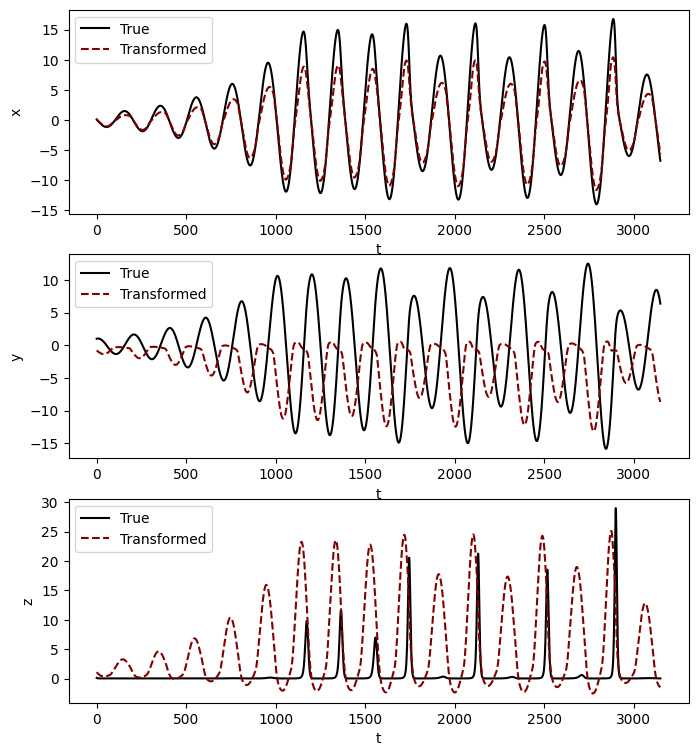

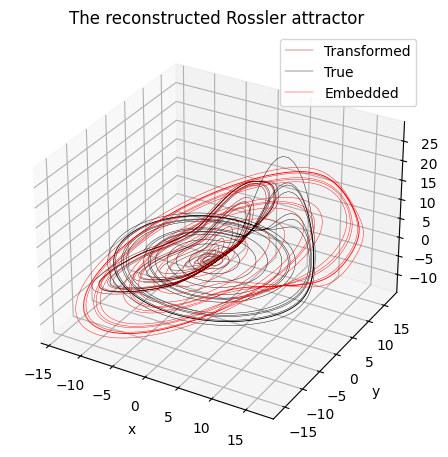

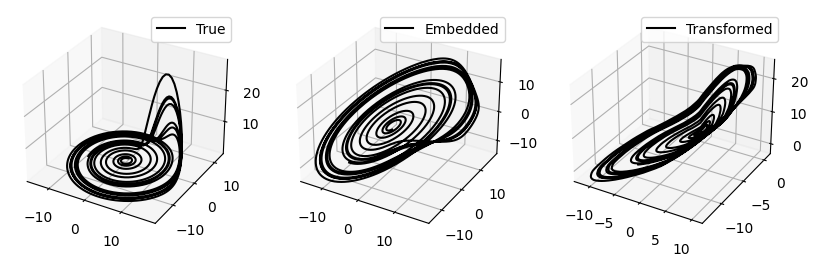

In [15]:
autoencoder.eval() 
latent_variables = autoencoder.encode(v)
# phi = autoencoder.phi(latent_variables).detach().numpy()
# coef = autoencoder.coefficients.detach().numpy()
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()
z_ae = latent_variables[:,2].detach().numpy()

plot(xs, ys, zs, v1, v2, v3, x_ae, y_ae, z_ae)

In [16]:
coef = autoencoder.coefficients.detach().numpy().T
library_names = ['*1', '*x', '*y', '*z', '*x**2', '*x*y', '*x*z', '*y**2', '*y*z', '*z**2']
var_names = ['x', 'y', 'z'] 
for i in range(len(var_names)):
    eqn = [f'{var_names[i]}_dot = ']
    for j in range(coef.shape[1]):
        if np.abs(coef[i, j]) > 0.01:
            eqn.append(f'+ {coef[i, j]} {library_names[j]}')
    print(''.join(eqn))

x_dot = + -0.19130972027778625 *z+ -0.6009508967399597 *x*y+ -1.126029133796692 *x*z
y_dot = + 0.8933629393577576 *x**2+ -0.32705235481262207 *x*y+ 0.048811085522174835 *x*z+ 0.8297913670539856 *y**2+ 0.5539146065711975 *y*z
z_dot = + -0.41011857986450195 *z+ 0.3664197027683258 *x**2


In [19]:
def SINDy_equs(X, t, P):
    x, y, z = X
    dx = -0.19130972027778625 *z + -0.6009508967399597 *x*y + -1.126029133796692 *x*z 
    dy = 0.8933629393577576 *x**2+ -0.32705235481262207 *x*y+ 0.048811085522174835 *x*z+ 0.8297913670539856 *y**2+ 0.5539146065711975 *y*z
    dz = -0.41011857986450195 *z + 0.3664197027683258 *x**2 
    return dx, dy, dz

x_s, y_s, z_s = Solution(SINDy_equs, np.array([x_ae[0], y_ae[0], z_ae[0]]), t[:len(x_ae)], [0,0,0])

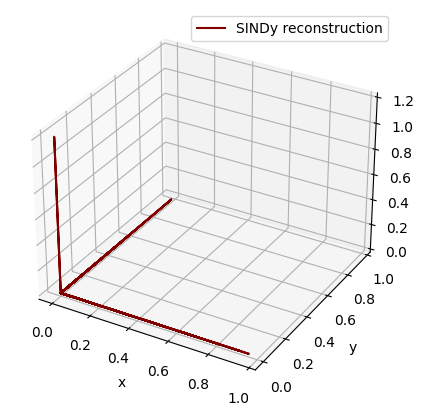

In [23]:
coef = autoencoder.coefficients.detach().numpy()
sol =  sindy_simulate(np.array([x_ae[0], y_ae[0], z_ae[0]]), t[:len(x_ae)], coef, 2, include_sine=False, exact_features=False)
x_si, y_si, z_si = sol[:,0], sol[:,1], sol[:,2]


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')
# ax.plot(x_s, y_s, z_s,color = 'k')
ax.plot(x_si, y_si, z_si,color = 'maroon', label = "SINDy reconstruction")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("z")
plt.legend()
plt.show()